# Fitting formulae accuracy

To test the accuracy of the Taylor expansion, we need to fit the measured moments by some analytical function. To check the accuracy of the fit, we generate Gaussian or ST models with the fitted moments, and compare how these reproduce the multipoles against the full measured model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from streaming.models.measured import Measured
from streaming.models import stream
import copy

In [2]:
import matplotlib.font_manager
import matplotlib as mpl
mpl.style.use('~/StreamingModel/streaming/utils/mplstyle')

In [3]:
pdf_filename = "../data/pairwise_velocity_pdf.hdf5"
tpcf_filename = "../data/tpcf.hdf5"

simulation = Measured(pdf_filename, tpcf_filename)

gaussian = stream.Stream(simulation, 'gaussian')


## Best fit to the mean

In [4]:
def m_10_fit(r,  a, b, c):
    
    return -a * np.exp(-b * r) + c

popt_m_10, pcov = curve_fit(m_10_fit,
            simulation.r[15:100], simulation.m_10.mean(simulation.r[15:100]))

/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


## Best fits to radial and tangential c_2

In [5]:
def c_20_fit(r, a, b, c):
    
    return - a * np.exp(-b * r) + c

popt_c_20, pcov = curve_fit(c_20_fit, simulation.r[5:60],
            simulation.c_20.mean(simulation.r[5:60]),  p0 = (3., 0.01,0))


In [6]:
def c_02_fit(r, a, b, c):
    
    return a * r**c + b

popt_c_02, pcov = curve_fit(c_02_fit, simulation.r[5:60],
            simulation.c_02.mean(simulation.r[5:60]))

In [30]:
best_fit_moments = {
            'm_10': {'function': m_10_fit, 'popt': popt_m_10},
            'c_20': {'function': c_20_fit, 'popt': popt_c_20},
            'c_02': {'function': c_02_fit, 'popt': popt_c_02},
        }

measured_moments = {
            'm_10': {'function': simulation.m_10.mean, 'popt': ()},
            'c_20': {'function': simulation.c_20.mean, 'popt': ()},
            'c_02': {'function': simulation.c_02.mean, 'popt': ()},
            'c_30': {'function': simulation.c_30.mean, 'popt': ()},
            'c_12': {'function': simulation.c_12.mean, 'popt': ()},
            'c_22': {'function': simulation.c_22.mean, 'popt': ()},
            'c_40': {'function': simulation.c_40.mean, 'popt': ()},
            'c_04': {'function': simulation.c_04.mean, 'popt': ()},

}

In [8]:
# Using all fitted moments:
gaussian_reduced = stream.Stream(simulation, 'gaussian',
                        best_fit_moments = best_fit_moments)

In [9]:
#sim_measurement_best_fit = copy.deepcopy(simulation)

#for key in best_fit_moments:

#    mean =  lambda r: best_fit_moments[key]['function'](r, *best_fit_moments[key]['popt']) 
#    setattr(getattr(sim_measurement_best_fit, key), 'mean', mean)


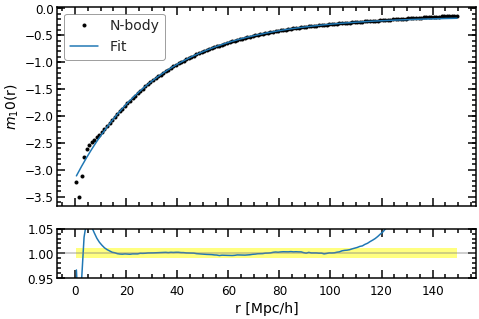

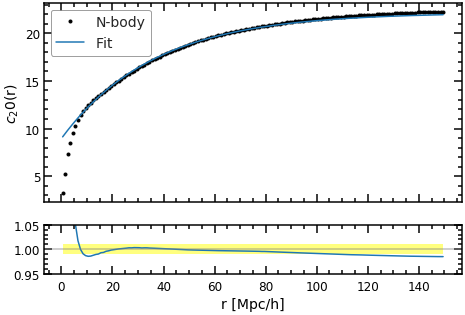

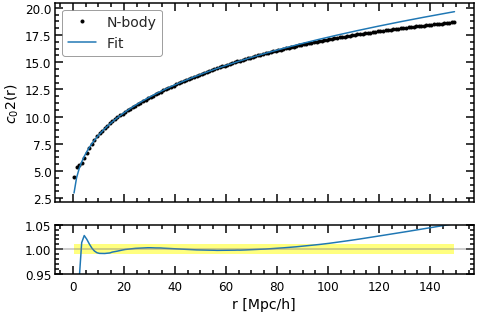

In [11]:
for key in best_fit_moments:

    fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                              gridspec_kw = {'height_ratios':[4,1]})

    ax1.plot(simulation.r, measured_moments[key]['function'](simulation.r), marker = 'o',
            markersize = 3, linestyle ='', color ='k', label = 'N-body')

    ax1.plot(simulation.r, best_fit_moments[key]['function'](simulation.r,
                    *best_fit_moments[key]['popt']), label = 'Fit')

    ax1.legend()


    ax2.plot(simulation.r,
              best_fit_moments[key]['function'](simulation.r,
                    *best_fit_moments[key]['popt'])/measured_moments[key]['function'](simulation.r))


    #plt.xlim(5,100)
    ax2.fill_between(simulation.r, 0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
    ax2.axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)
    ax2.set_ylim(0.95,1.05)

    ax1.set_ylabel(f'${key}$(r)')
    ax2.set_xlabel('r [Mpc/h]')
    
    plt.show()

## Test accuracy of fitting formulae by replacing the measured moments for the fitted ones in the Gaussian Streaming Model, one at a time

In [12]:
reduced_models = []

for key in best_fit_moments:
    # copy all measured moments
    moments = copy.deepcopy(measured_moments)
    # subtitute for fitted one at a time
    moments[key] = best_fit_moments[key]
    
    gaussian_reduced = stream.Stream(simulation, 'gaussian',
                        best_fit_moments = moments)
    
    reduced_models.append(gaussian_reduced)

In [15]:
import importlib
importlib.reload(stream)

<module 'streaming.models.stream' from '/cosma/home/dp004/dc-cues1/StreamingModel/streaming/models/stream.py'>

In [13]:
colors = ['forestgreen', 'orange', 'purple']

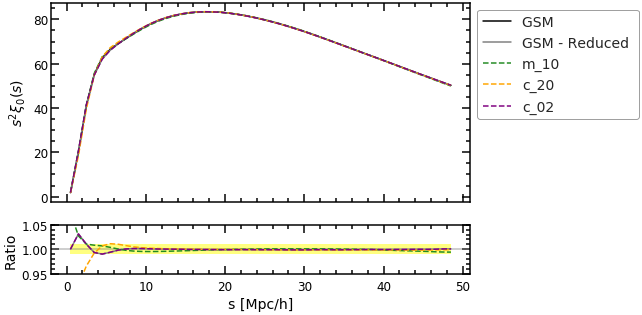

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c **2* gaussian.monopole, 
         label = 'GSM ', color='black')

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c **2 * gaussian_reduced.monopole, 
         label = 'GSM - Reduced ', color='gray')

for i, key in enumerate(best_fit_moments):

    ax1.plot(reduced_models[i].s_c, reduced_models[i].s_c**2 * reduced_models[i].monopole, 
         linestyle='dashed', color = colors[i],
         label = key)

ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)

ax2.plot(gaussian.s_c,  gaussian_reduced.monopole/gaussian.monopole, 
         color = 'gray')

for i, key in enumerate(best_fit_moments):

    ax2.plot(reduced_models[i].s_c,  reduced_models[i].monopole/gaussian.monopole, 
         linestyle='dashed', color = colors[i],
         label = key)

    
ax1.set_ylabel(r'$s^2 \xi_0 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.set_ylabel(r'Ratio')

ax2.set_ylim(0.95,1.05)
#ax1.set_ylim(-5.,25)

ax1.legend(bbox_to_anchor=(1,1))

Monopole within 1 % for scales > 6 Mpc/h

(0.95, 1.05)

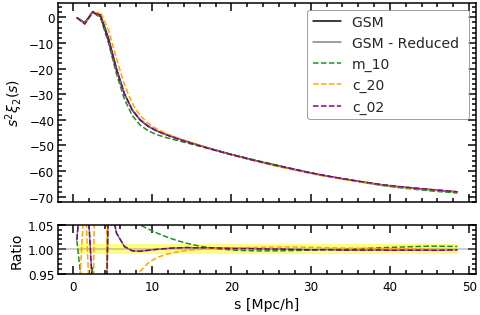

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c **2* gaussian.quadrupole, 
         label = 'GSM ', color='black')

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c **2 * gaussian_reduced.quadrupole, 
         label = 'GSM - Reduced ', color='gray')

for i, key in enumerate(best_fit_moments):

    ax1.plot(reduced_models[i].s_c, reduced_models[i].s_c**2 * reduced_models[i].quadrupole, 
         linestyle='dashed', color = colors[i],
         label = key)

ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)

ax2.plot(gaussian.s_c,  gaussian_reduced.quadrupole/gaussian.quadrupole, 
         color = 'gray')

for i, key in enumerate(best_fit_moments):

    ax2.plot(reduced_models[i].s_c,  reduced_models[i].quadrupole/gaussian.quadrupole, 
         linestyle='dashed', color = colors[i],
         label = key)

    
ax1.set_ylabel(r'$s^2 \xi_2 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.set_ylabel(r'Ratio')

ax1.legend(bbox_to_anchor=(1,1))
ax2.set_ylim(0.95,1.05)



Quadrupole within 1% for scals larger than 9 Mpc/h

(0.95, 1.05)

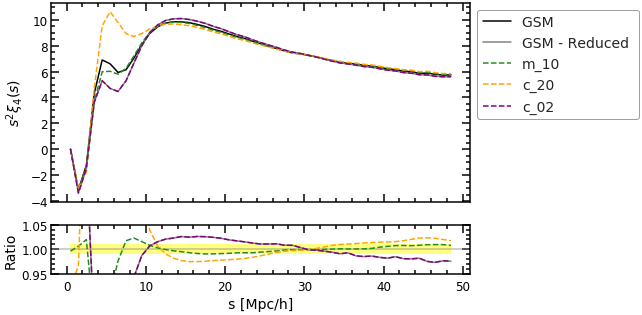

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c **2* gaussian.hexadecapole, 
         label = 'GSM ', color='black')

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c **2 * gaussian_reduced.hexadecapole, 
         label = 'GSM - Reduced ', color='gray')

for i, key in enumerate(best_fit_moments):

    ax1.plot(reduced_models[i].s_c, reduced_models[i].s_c**2 * reduced_models[i].hexadecapole, 
         linestyle='dashed', color = colors[i],
         label = key)

ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)

ax2.plot(gaussian.s_c,  gaussian_reduced.hexadecapole/gaussian.hexadecapole, 
         color = 'gray')

for i, key in enumerate(best_fit_moments):
    ax2.plot(reduced_models[i].s_c,  reduced_models[i].hexadecapole/gaussian.hexadecapole, 
         linestyle='dashed', color = colors[i],
         label = key)

    
ax1.set_ylabel(r'$s^2 \xi_4 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.set_ylabel(r'Ratio')

ax1.legend(bbox_to_anchor=(1,1))
ax2.set_ylim(0.95,1.05)


hexadecapole within 5% for scales larger tan 10 Mpc/h

## Higher order moments: same check with ST

In [33]:
def c_30_fit(r, a, b,c):
    return a/np.sqrt(r) + b * np.log10(r)  + c

popt_c_30, pcov = curve_fit(c_30_fit, simulation.r[5:60],
                    simulation.c_30.mean(simulation.r[5:60]))

best_fit_moments['c_30'] = {'function': c_30_fit, 'popt': popt_c_30}

In [34]:
def c_12_fit(r, a, b,c):
    return a/np.sqrt(r) + b * np.log10(r)  + c

popt_c_12, pcov = curve_fit(c_12_fit, simulation.r[5:60],
                    simulation.c_12.mean(simulation.r[5:60]))

best_fit_moments['c_12'] = {'function': c_12_fit, 'popt': popt_c_12}

In [35]:
def c_22_fit(r, a, b,c):
    return a/np.sqrt(r) + b * np.log10(r)  + c

popt_c_22, pcov = curve_fit(c_22_fit, simulation.r[5:60],
                    simulation.c_22.mean(simulation.r[5:60]))

best_fit_moments['c_22'] = {'function': c_22_fit, 'popt': popt_c_22}

In [36]:
def c_40_fit(r, a, b,c):
    return a/np.sqrt(r) + b * np.log10(r)  + c

popt_c_40, pcov = curve_fit(c_40_fit, simulation.r[5:60],
                    simulation.c_40.mean(simulation.r[5:60]))

best_fit_moments['c_40'] = {'function': c_40_fit, 'popt': popt_c_40}

In [37]:
def c_04_fit(r, a, b,c):
    return a/np.sqrt(r) + b * np.log10(r)  + c

popt_c_04, pcov = curve_fit(c_04_fit, simulation.r[5:60],
                    simulation.c_04.mean(simulation.r[5:60]))

best_fit_moments['c_04'] = {'function': c_04_fit, 'popt': popt_c_04}

In [38]:
best_fit_moments.keys()

dict_keys(['m_10', 'c_20', 'c_02', 'c_30', 'c_12', 'c_22', 'c_40', 'c_04'])

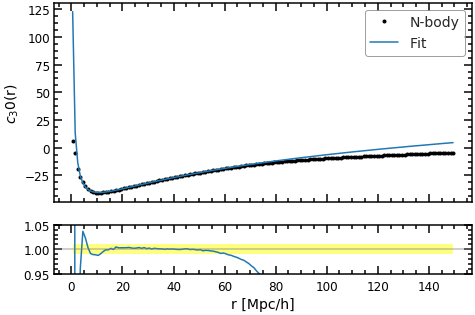

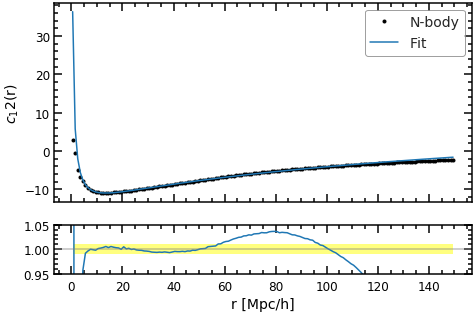

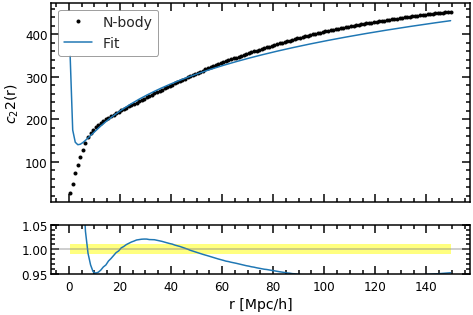

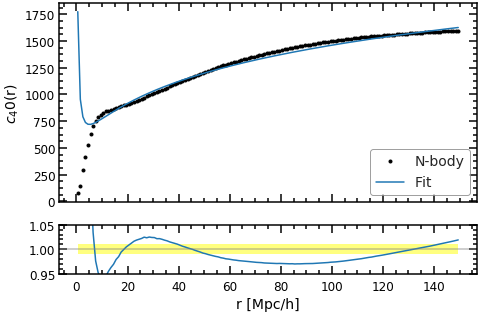

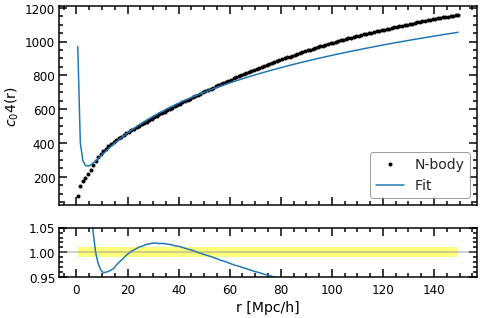

In [39]:
for key in list(best_fit_moments.keys())[3:]:

    fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                              gridspec_kw = {'height_ratios':[4,1]})

    ax1.plot(simulation.r, measured_moments[key]['function'](simulation.r), marker = 'o',
            markersize = 3, linestyle ='', color ='k', label = 'N-body')

    ax1.plot(simulation.r, best_fit_moments[key]['function'](simulation.r,
                    *best_fit_moments[key]['popt']), label = 'Fit')

    ax1.legend()


    ax2.plot(simulation.r,
              best_fit_moments[key]['function'](simulation.r,
                    *best_fit_moments[key]['popt'])/measured_moments[key]['function'](simulation.r))


    #plt.xlim(5,100)
    ax2.fill_between(simulation.r, 0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
    ax2.axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)
    ax2.set_ylim(0.95,1.05)

    ax1.set_ylabel(f'${key}$(r)')
    ax2.set_xlabel('r [Mpc/h]')
    
    plt.show()

In [46]:
# Using all measured moments:
skewt = stream.Stream(simulation, 'skewt')

Found ST parameters from moments


In [41]:
# Using all fitted moments:
skewt_reduced = stream.Stream(simulation, 'skewt',
                        best_fit_moments = best_fit_moments)

/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Found ST parameters from moments


In [44]:
skewt_reduced_models = []

for key in list(best_fit_moments.keys())[3:]:
    # copy all measured moments
    moments = copy.deepcopy(measured_moments)
    # subtitute for fitted one at a time
    moments[key] = best_fit_moments[key]
    
    gaussian_reduced = stream.Stream(simulation, 'skewt',
                        best_fit_moments = moments)
    
    skewt_reduced_models.append(gaussian_reduced)

/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Found ST parameters from moments
Found ST parameters from moments
Found ST parameters from moments
Found ST parameters from moments
Found ST parameters from moments


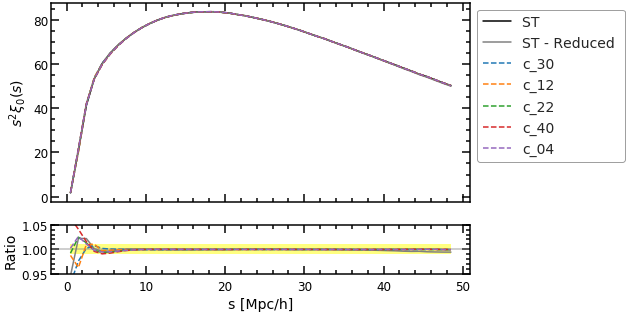

In [57]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(skewt_reduced.s_c, 
         skewt_reduced.s_c **2* skewt.monopole, 
         label = 'ST ', color='black')

ax1.plot(skewt_reduced.s_c, 
         skewt_reduced.s_c **2 * skewt_reduced.monopole, 
         label = 'ST - Reduced ', color='gray')

for i, key in enumerate(list(best_fit_moments.keys())[3:]):

    ax1.plot(skewt_reduced_models[i].s_c, skewt_reduced_models[i].s_c**2 * skewt_reduced_models[i].monopole, 
         linestyle='dashed', #color = colors[i],
         label = key)

ax2.fill_between(skewt.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)

ax2.plot(skewt.s_c,  skewt_reduced.monopole/skewt.monopole, 
         color = 'gray')

for i, key in enumerate(list(best_fit_moments.keys())[3:]):

    ax2.plot(skewt_reduced_models[i].s_c,  skewt_reduced_models[i].monopole/skewt.monopole, 
         linestyle='dashed',# color = colors[i],
         label = key)

    
ax1.set_ylabel(r'$s^2 \xi_0 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.set_ylabel(r'Ratio')

ax2.set_ylim(0.95,1.05)
#ax1.set_ylim(-5.,25)

ax1.legend(bbox_to_anchor=(1,1))

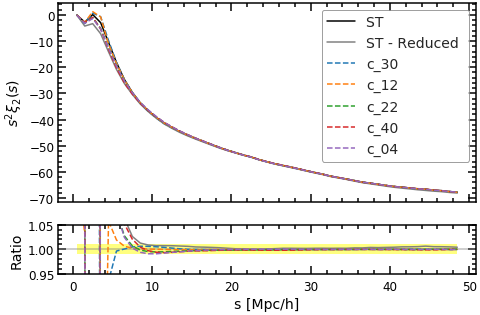

In [56]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(skewt_reduced.s_c, 
         skewt_reduced.s_c **2* skewt.quadrupole, 
         label = 'ST ', color='black')

ax1.plot(skewt_reduced.s_c, 
         skewt_reduced.s_c **2 * skewt_reduced.quadrupole, 
         label = 'ST - Reduced ', color='gray')

for i, key in enumerate(list(best_fit_moments.keys())[3:]):

    ax1.plot(skewt_reduced_models[i].s_c, skewt_reduced_models[i].s_c**2 * skewt_reduced_models[i].quadrupole, 
         linestyle='dashed', #color = colors[i],
         label = key)

ax2.fill_between(skewt.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)

ax2.plot(skewt.s_c,  skewt_reduced.quadrupole/skewt.quadrupole, 
         color = 'gray')

for i, key in enumerate(list(best_fit_moments.keys())[3:]):

    ax2.plot(skewt_reduced_models[i].s_c,  skewt_reduced_models[i].quadrupole/skewt.quadrupole, 
         linestyle='dashed',# color = colors[i],
         label = key)

    
ax1.set_ylabel(r'$s^2 \xi_2 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.set_ylabel(r'Ratio')

ax2.set_ylim(0.95,1.05)
#ax1.set_ylim(-5.,25)

ax1.legend(bbox_to_anchor=(1,1))

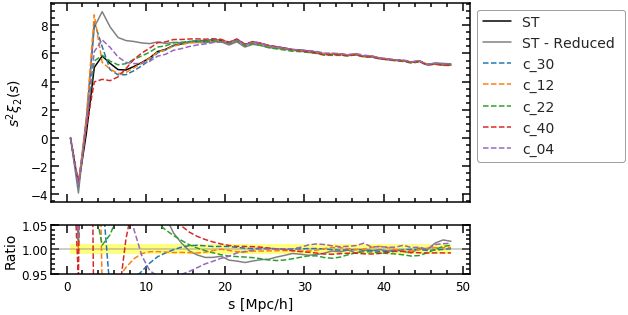

In [58]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(skewt_reduced.s_c, 
         skewt_reduced.s_c **2* skewt.hexadecapole, 
         label = 'ST ', color='black')

ax1.plot(skewt_reduced.s_c, 
         skewt_reduced.s_c **2 * skewt_reduced.hexadecapole, 
         label = 'ST - Reduced ', color='gray')

for i, key in enumerate(list(best_fit_moments.keys())[3:]):

    ax1.plot(skewt_reduced_models[i].s_c, skewt_reduced_models[i].s_c**2 * skewt_reduced_models[i].hexadecapole, 
         linestyle='dashed', #color = colors[i],
         label = key)

ax2.fill_between(skewt.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)

ax2.plot(skewt.s_c,  skewt_reduced.hexadecapole/skewt.hexadecapole, 
         color = 'gray')

for i, key in enumerate(list(best_fit_moments.keys())[3:]):

    ax2.plot(skewt_reduced_models[i].s_c,  skewt_reduced_models[i].hexadecapole/skewt.hexadecapole, 
         linestyle='dashed',# color = colors[i],
         label = key)

    
ax1.set_ylabel(r'$s^2 \xi_4 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.set_ylabel(r'Ratio')

ax2.set_ylim(0.95,1.05)
#ax1.set_ylim(-5.,25)

ax1.legend(bbox_to_anchor=(1,1))